In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rand

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (16, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [2]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

def unnormalize(df, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * df.std() + df.mean()
    else:
        # min max normalization
        unnormalized_df = (df * (df.max() - df.min())) + df.min()
    return unnormalized_df

# Linear Regression

In [3]:
class Linear_Regression:
    
    def __init__(self, x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-10, 
                                         step_size = 1e-1):
        
        # init weights 
        self.weights = np.zeros(x_train.shape[1])
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test      
        
        # init vars
        self.max_iters = int(max_iters)
        self.tolerance = tolerance
        self.step_size = step_size
        
    
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])
    
    
    def gradient_descent(self, x_train, y_train, weights):        
        
        y_pred = x_train.dot(weights)
        init_loss = self.MSE(y_pred, y_train) 
        
        store_loss = []
        store_loss.append(init_loss)
        
        for i in range(self.max_iters):
            
            # calc predicted y with weights and resulting error
            y_pred = x_train.dot(weights)
            error = y_pred - y_train
            
            # calc gradient and adjust weights in direction of negative grad
            grad = x_train.T.dot(error) / x_train.shape[0]
            weights -= grad*self.step_size 
            
            # calc and store loss of new y predicted
            y_pred = x_train.dot(weights)
            store_loss.append(self.MSE(y_pred, y_train) )
            
            # if the progress is less than the tolerance, it has converged
            if np.abs( store_loss[-2] - store_loss[-1] ) <= self.tolerance:
                print('Converged!')
                break
            
            # decrease step size if error increases
            if store_loss[-1] > store_loss[-2]:
                self.step_size *= 0.50
            
        return weights, store_loss
        
    def predict(self):   
        
        # perform gradient descent
        optimal_weights, store_loss = self.gradient_descent(self.x_train, 
                                                            self.y_train,
                                                            self.weights)
        
        y_pred = self.x_test.dot(optimal_weights) 
        MSE = self.MSE(y_pred, y_test)
        
        return y_pred, MSE, store_loss, optimal_weights

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

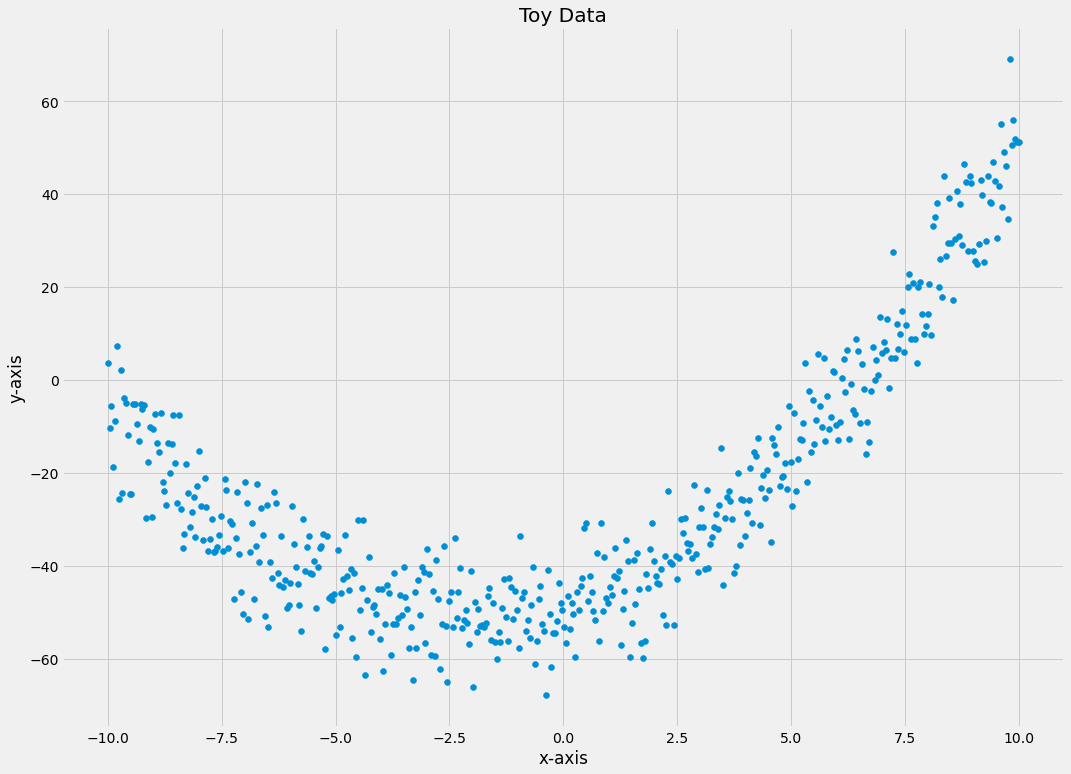

In [4]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 500)
    
    y = []
    
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            
    return x, y
    
x, y = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [5]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]
x_valid, y_valid = validation.iloc[:,:-1], validation.iloc[:,-1]

# instantiate LR class and fit model to data
LR = Linear_Regression(x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-10, 
                                         step_size = 1e-1)
y_pred, MSE, loss, weights = LR.predict()
print("Mean Squared Error: {}".format(MSE))

Converged!
Mean Squared Error: 0.2842413003818185


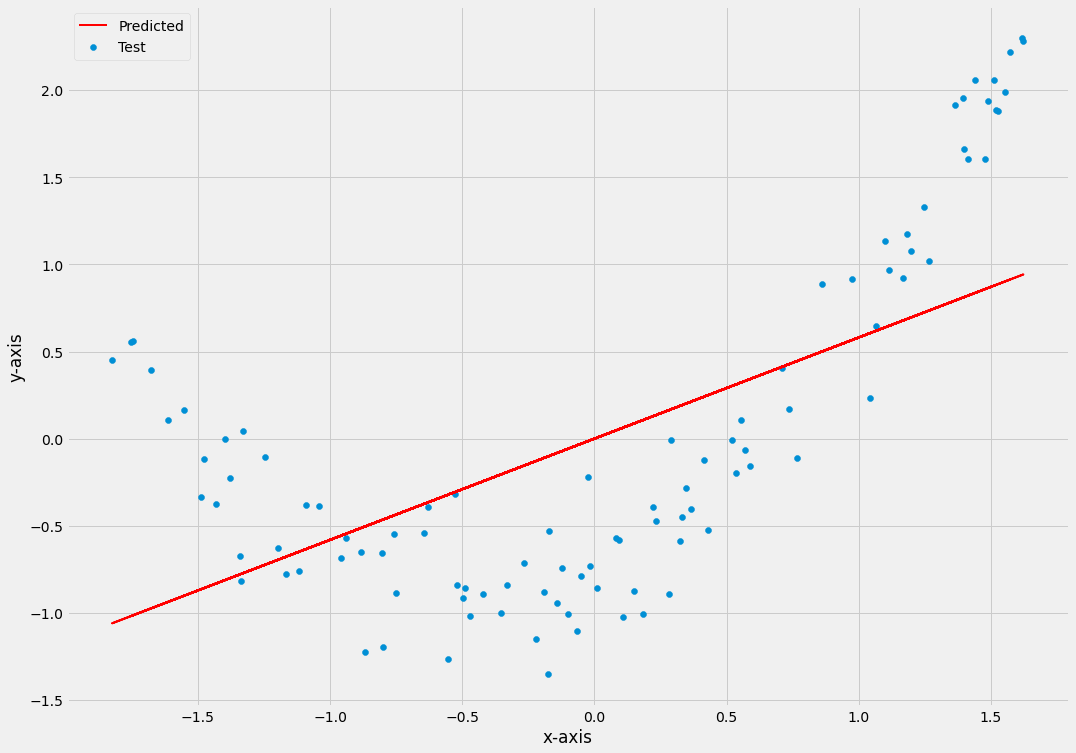

In [7]:
plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(x_test,y_pred, 
         c = 'red', 
         linewidth = 2, 
         label = 'Predicted')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

In [8]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
#train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
xTrain, yTrain = train.iloc[:,:-1], train.iloc[:,-1]
xTest, yTest = test.iloc[:,:-1], test.iloc[:,-1]
xValid, yValid = validation.iloc[:,:-1], validation.iloc[:,-1]

# normalize input data 
x_train, x_test, x_valid = normalize(xTrain), normalize(xTest), normalize(xValid)
y_train, y_test, y_valid = yTrain, yTest, yValid

# Run Model to Predict Crop Yield

In [9]:
LR = Linear_Regression(x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-10, 
                                         step_size = 1e-1)
y_pred, MSE, loss, weights = LR.predict()
print("Mean Squared Error: {}".format(MSE))
df_w = pd.DataFrame(weights, columns = ['Coefficient'])
np.transpose(df_w)

Converged!
Mean Squared Error: 10.77879708583193


,jan rain,jan mean min temperature,jan mean max temperature,feb rain,feb mean min temperature,feb mean max temperature,mar rain,mar mean min temperature,mar mean max temperature,apr rain,...,sep mean max temperature,oct rain,oct mean min temperature,oct mean max temperature,nov rain,nov mean min temperature,nov mean max temperature,dec rain,dec mean min temperature,dec mean max temperature
Coefficient,0.037877,0.487004,-0.288989,0.277798,-0.089493,-0.996561,0.168975,-1.137558,1.419647,0.119306,...,0.308695,0.095933,0.575404,-0.924671,0.134139,-0.030314,0.238027,0.193625,-0.188102,0.322472


In [10]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

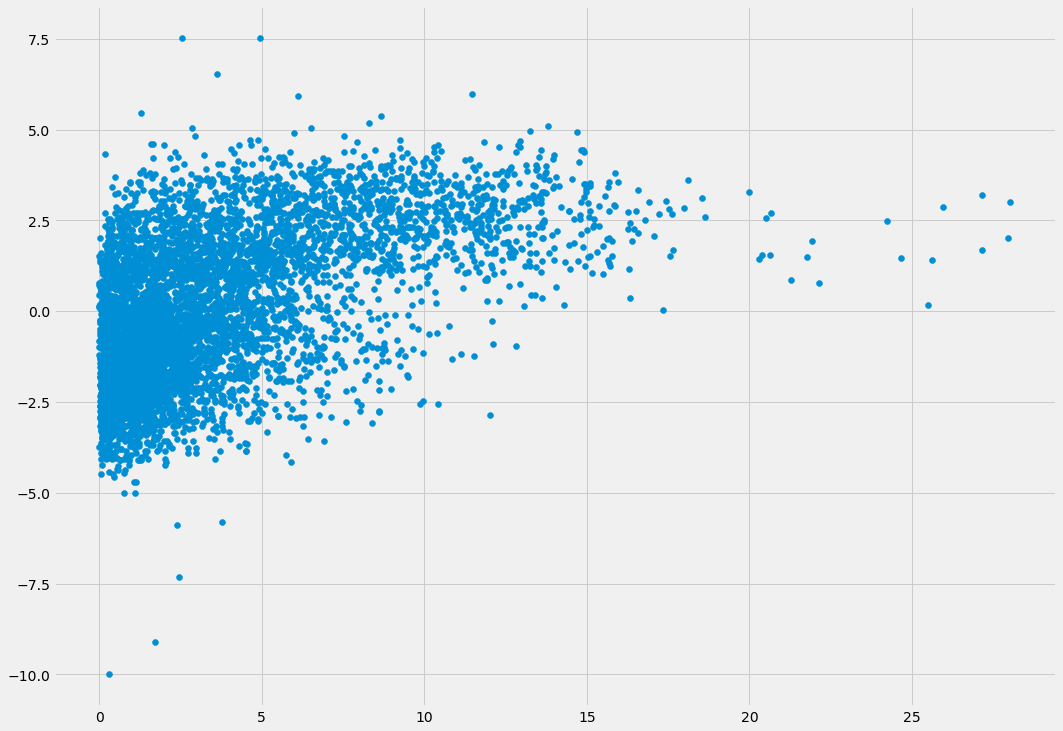

In [11]:
plt.scatter(df_pred['y_test'], df_pred['y_pred'])

In [12]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.552899
y_pred,0.552899,1.000000
